# CS7641 Machine Learning
### <i>Application of Machine Learning in Pairs Trading</i>

## Data Filtering
Our dataset contains two datasets: daily stock price data and monthly firm-level financial ratios data. We preselect stocks from Russel 3000 which can idealy represent 98% of total market shares of the U.S. Equity Market. Then we perform basic data screening and stock filtering to eliminate stocks that would affect our results.

- Training set sample period: 2010/01/01 to 2015/12/31, use for clustering and training trading model
- Testing period: 2016/01/01 to 2019/12/31, use for testing trading model

### 1. Daily Stock Price Dataset
 - Delete stocks that are delisted during sample period (since we cannot trade them anymore)
 - Delete stocks that have negative stock price during sample period (will be problematic when trading)
 - Delete stocks that have long-time low trading volumn (avoid illiquidity trap)
 - Delete stocks that have more than half missing data (avoid funtionality error for PCA)

This left us with 2060 stocks in total.

### 2. Monthly Financial Ratios Dataset
We use 20 financial ratios, including 
 - Asset Turnover
 - BM (Book/Market)
 - Capitalization Ratio
 - Cash Flow/Total Debt
 - Cash Flow Margin
 - Current Ratio
 - DE ratio (Total Debt/Equity)
 - Total Debt/EBITDA
 - Free Cash Flow/Operating Cash Flow
 - Gross Profit/Total Assets
 - Interest Coverage Ratio
 - Long-term Debt/Total Liabilities
 - Net Profit Margin
 - P/E (Diluted, Excluding El)
 - Pre-tax Return on Total Earning Assets
 - Return on Assets
 - Return on Equity
 - Price/Book
 - Quick Ratio
 - Total Debt/Invested Capital

We may exclude some ratios if their are too many missing data

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import missingno as msno

### 1. Stock Price

In [8]:
#import stock price dataset
price = pd.read_csv("~/Downloads/russel3000PriceDaily.csv")

/Users/Sharonvy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
#take a glance of original price dataset
price.head()

,PERMNO,date,SICCD,TICKER,DLSTCD,PRC,VOL,RET,SHROUT,RETX
0,10025,20070103,3070,AEPI,NaN,49.06,112525.0,-0.079722,7886.0,-0.079722
1,10025,20070104,3070,AEPI,NaN,50.34,87697.0,0.026090,7886.0,0.026090
2,10025,20070105,3070,AEPI,NaN,49.63,43162.0,-0.014104,7886.0,-0.014104
3,10025,20070108,3070,AEPI,NaN,49.50,37778.0,-0.002619,7886.0,-0.002619
4,10025,20070109,3070,AEPI,NaN,50.62,40393.0,0.022626,7886.0,0.022626


In [10]:
print("Original dataset size: ", len(price))
print("Original number of stocks: ", len(set(price['PERMNO'])))

Original dataset size:  8497689
Original number of stocks:  3292


In [11]:
#preprocessing
price['_date'] = pd.to_datetime(price['date'], format = '%Y%m%d')
price['turnover'] = price['VOL']/price['SHROUT']

#delisted stocks
dlst = price[price['DLSTCD'] >= 300]        #those are companies that are liquidated, dropped or exhanged during sample period
dlst_list = list(set(dlst['PERMNO']))       #and should be exclude in our training set (since we cannot trade them anymore)

#negative price stocks
neg_price = price[price['PRC'] <= 0]        #delete stocks with negative price (will be problematic when trading)
neg_price_list = list(set(neg_price['PERMNO']))

#low trading volume
low_vol = price[price['turnover'] <= 0.1]   #if the daily trading volume is less than 0.1% of its total shares outstanding
low_vol_list = list(set(low_vol['PERMNO']))
for item in low_vol_list:
    temp = low_vol.loc[low_vol['PERMNO'] == item]
    if len(temp) < 100:                     #avoid deleting too many stocks (data collection error or temporary derail)
        low_vol_list.remove(item)

In [12]:
#stocks that we want to exclude
final_list = list(set(dlst_list) | set(neg_price_list) | set(low_vol_list))
#final dataset for price
stock_price = price.loc[price['PERMNO'].isin(final_list) == False]

In [13]:
print("Dataset size: ", len(stock_price))
print("Number of stocks: ", len(set(stock_price['PERMNO'])))

Dataset size:  7255941
Number of stocks:  2740


In [14]:
#set training set sample period for clsutering analysis, from 2010/01/01 to 2015/12/31
#and set testing dataset from 2016/01/01 to 2019/12/31
price_train = stock_price.loc[stock_price['date'] < 20160101]
price_test = stock_price.loc[stock_price['date'] >= 20160101]

In [15]:
#get the pivot table, with stock permno as index and datetime as columns
df_price = pd.pivot_table(price_train, values = 'PRC', index = 'PERMNO', columns = 'date')
df_price = df_price.add_prefix('price_')
#last step, delete stocks with more than half nan price for clustering
df_price = df_price.dropna(thresh = len(df_price.columns)//2)
df_price = df_price.fillna(method = 'ffill', axis = 1, limit = 5)

In [16]:
df_price.head()

date,price_20070103,price_20070104,price_20070105,price_20070108,price_20070109,price_20070110,price_20070111,price_20070112,price_20070116,price_20070117,...,price_20151217,price_20151218,price_20151221,price_20151222,price_20151223,price_20151224,price_20151228,price_20151229,price_20151230,price_20151231
PERMNO,,,,,,,,,,,,,,,,,,,,,
10025,49.06,50.34,49.63,49.50,50.62,49.68,49.20,48.90,46.83,47.05,...,80.80,79.01,76.40,77.93,78.98,80.55,78.97,77.15,77.22,77.15
10026,41.02,41.89,39.66,40.42,40.54,41.54,41.41,42.23,41.71,41.28,...,114.37,112.69,112.92,114.53,115.90,118.21,117.64,119.37,119.25,116.67
10032,24.12,24.30,23.89,23.70,23.13,20.90,20.84,21.58,20.79,20.58,...,35.26,34.99,35.22,35.08,35.95,36.05,35.67,35.92,35.46,34.92
10051,7.40,7.33,7.52,7.44,7.51,7.52,7.45,7.60,7.83,7.82,...,17.53,16.77,16.52,17.08,17.29,17.38,16.96,16.95,16.85,16.45
10104,17.51,17.68,17.64,17.86,17.82,17.77,17.39,17.50,17.30,17.52,...,36.93,36.35,36.42,36.59,36.93,37.01,36.79,37.04,36.92,36.53


In [17]:
print("Number of training stocks: ", len(df_price))

Number of training stocks:  2105


In [18]:
#get the list permno for further data extraction
permno = list(df_price.index)
with open('permno_list.txt', 'w') as filehandle:    #write to file
    for listitem in permno:
        filehandle.write('%i\n' % listitem)

### 2. Financial Ratios

In [24]:
#import financial ratios dataset
ratios = pd.read_csv("~/Downloads/financialRatiosMonthly.csv")
ratios.head()

,permno,adate,qdate,public_date,bm,pe_exi,npm,cfm,roa,roe,...,debt_ebitda,lt_debt,cash_debt,fcf_ocf,de_ratio,intcov_ratio,quick_ratio,curr_ratio,at_turn,ptb
0,10025,20091031.0,20091031,20100131,0.365,7.845,0.041,0.068,0.212,0.473,...,2.221,0.615,0.31,0.729,3.750,3.834,1.010,1.797,1.984,2.740
1,10025,20091031.0,20091031,20100228,0.365,7.843,0.041,0.068,0.212,0.473,...,2.221,0.615,0.31,0.729,3.750,3.834,1.010,1.797,1.984,2.740
2,10025,20091031.0,20100131,20100331,0.338,13.208,0.019,0.047,0.148,0.183,...,3.620,0.657,0.31,0.289,3.963,2.079,1.057,2.013,2.055,2.204
3,10025,20091031.0,20100131,20100430,0.338,14.025,0.019,0.047,0.148,0.183,...,3.620,0.657,0.31,0.289,3.963,2.079,1.057,2.013,2.055,2.340
4,10025,20091031.0,20100131,20100531,0.338,12.761,0.019,0.047,0.148,0.183,...,3.620,0.657,0.31,0.289,3.963,2.079,1.057,2.013,2.055,2.129


In [25]:
#since the public date is already two month behind qdate (defined to be), we do not need to lag the data anymore
ratios['_date'] = pd.to_datetime(ratios['public_date'], format = '%Y%m%d').dt.to_period('M')
#select only training period
ratios_train = ratios.loc[ratios['public_date'] < 20160101]
ratios_train.tail()

,permno,adate,qdate,public_date,bm,pe_exi,npm,cfm,roa,roe,...,lt_debt,cash_debt,fcf_ocf,de_ratio,intcov_ratio,quick_ratio,curr_ratio,at_turn,ptb,_date
210721,93436,20141231.0,20150630,20150831,0.021,-60.159,-0.141,-0.059,-0.015,-0.569,...,0.374,-0.012,NaN,5.679,-2.784,0.955,1.421,0.620,43.507,2015-08
210722,93436,20141231.0,20150630,20150930,0.021,-60.000,-0.141,-0.059,-0.015,-0.569,...,0.374,-0.012,NaN,5.679,-2.784,0.955,1.421,0.620,35.349,2015-09
210723,93436,20141231.0,20150630,20151031,0.021,-49.983,-0.141,-0.059,-0.015,-0.569,...,0.374,-0.012,NaN,5.679,-2.784,0.955,1.421,0.620,37.849,2015-10
210724,93436,20141231.0,20150930,20151130,0.040,-43.201,-0.178,-0.087,-0.031,-0.791,...,0.350,-0.012,NaN,5.533,-3.607,0.783,1.272,0.583,22.936,2015-11
210725,93436,20141231.0,20150930,20151231,0.040,-45.030,-0.178,-0.087,-0.031,-0.791,...,0.350,-0.012,NaN,5.533,-3.607,0.783,1.272,0.583,23.994,2015-12


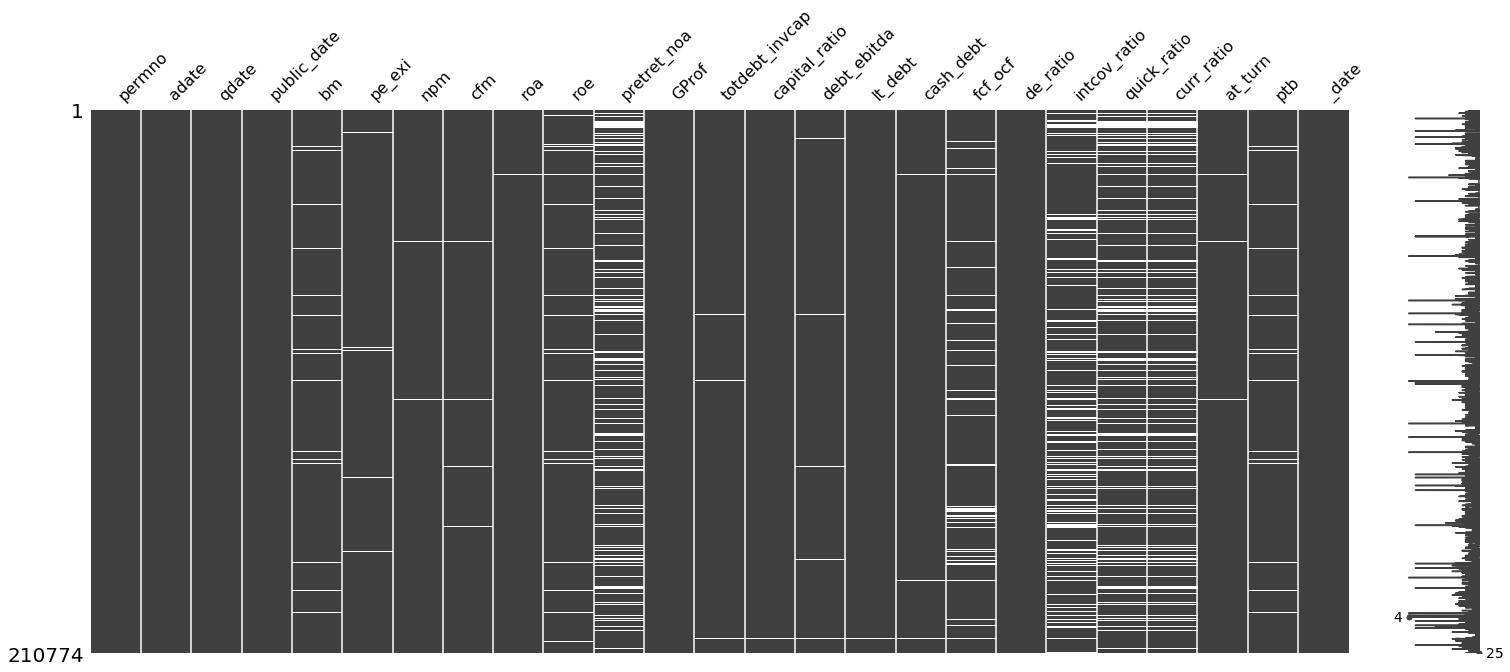

In [26]:
#visualize missing data
msno.matrix(ratios)

In [27]:
#pivot table for each ratio
df_bm = pd.pivot_table(ratios_train, values = 'bm', index = 'permno', columns = '_date')
df_bm = df_bm.add_prefix('bm_')
df_bm.head()

_date,bm_2010-01,bm_2010-02,bm_2010-03,bm_2010-04,bm_2010-05,bm_2010-06,bm_2010-07,bm_2010-08,bm_2010-09,bm_2010-10,...,bm_2015-03,bm_2015-04,bm_2015-05,bm_2015-06,bm_2015-07,bm_2015-08,bm_2015-09,bm_2015-10,bm_2015-11,bm_2015-12
permno,,,,,,,,,,,,,,,,,,,,,
10025,0.365,0.365,0.338,0.338,0.338,0.424,0.424,0.424,0.409,0.409,...,0.310,0.310,0.310,0.346,0.346,0.346,0.395,0.395,0.395,0.273
10026,0.462,0.504,0.504,0.504,0.472,0.472,0.472,0.504,0.504,0.504,...,0.299,0.299,0.309,0.309,0.309,0.307,0.307,0.307,0.303,0.303
10032,0.506,0.487,0.487,0.487,0.405,0.405,0.405,0.575,0.575,0.575,...,0.577,0.577,0.594,0.594,0.594,0.568,0.568,0.568,0.659,0.659
10051,0.741,0.779,0.779,0.779,0.599,0.599,0.599,0.631,0.631,0.631,...,0.701,0.701,0.579,0.579,0.579,0.564,0.564,0.564,0.981,0.981
10104,0.252,0.252,0.252,0.233,0.233,0.233,0.275,0.275,0.275,0.296,...,0.255,0.251,0.251,0.251,0.260,0.260,0.260,0.297,0.297,0.297


In [28]:
#setup the final training set for clustering
training_set = df_price

In [29]:
#merge all dataset using a for loop
ratios_list = ratios_train.columns[4:-2]
for r in ratios_list:
    temp_pivot = pd.pivot_table(ratios_train, values = r, index = 'permno', columns = '_date')
    temp_pivot = temp_pivot.add_prefix(r + '_')
    training_set = training_set.merge(temp_pivot, how = 'left', left_index = True, right_index = True)

In [30]:
training_set.head()

,price_20070103,price_20070104,price_20070105,price_20070108,price_20070109,price_20070110,price_20070111,price_20070112,price_20070116,price_20070117,...,at_turn_2015-03,at_turn_2015-04,at_turn_2015-05,at_turn_2015-06,at_turn_2015-07,at_turn_2015-08,at_turn_2015-09,at_turn_2015-10,at_turn_2015-11,at_turn_2015-12
PERMNO,,,,,,,,,,,,,,,,,,,,,
10025,49.06,50.34,49.63,49.50,50.62,49.68,49.20,48.90,46.83,47.05,...,2.628,2.628,2.628,2.674,2.674,2.674,2.730,2.730,2.730,2.573
10026,41.02,41.89,39.66,40.42,40.54,41.54,41.41,42.23,41.71,41.28,...,1.340,1.340,1.348,1.348,1.348,1.357,1.357,1.357,1.349,1.349
10032,24.12,24.30,23.89,23.70,23.13,20.90,20.84,21.58,20.79,20.58,...,1.604,1.604,1.623,1.623,1.623,1.627,1.627,1.627,1.603,1.603
10051,7.40,7.33,7.52,7.44,7.51,7.52,7.45,7.60,7.83,7.82,...,0.786,0.786,0.787,0.787,0.787,0.822,0.822,0.822,0.834,0.834
10104,17.51,17.68,17.64,17.86,17.82,17.77,17.39,17.50,17.30,17.52,...,0.414,0.401,0.401,0.401,0.380,0.380,0.380,0.365,0.365,0.365


In [31]:
#last step, delete stocks with more than half features is missing
training_set = training_set.dropna(thresh = len(training_set.columns)//2)
print("Number of stocks in training set: ", len(training_set))

Number of stocks in training set:  2060


In [32]:
#save training set to file
training_set.to_csv('training_data.csv')

In [33]:
#filtering stocks for testing dataset
testing_set = price_test.loc[price_test['PERMNO'].isin(training_set.index)]
testing_set.head()

,PERMNO,date,SICCD,TICKER,DLSTCD,PRC,VOL,RET,SHROUT,RETX,_date,turnover
2266,10025,20160104,3081,AEPI,NaN,73.19,29246.0,-0.051329,5103.0,-0.051329,2016-01-04,5.731139
2267,10025,20160105,3081,AEPI,NaN,74.40,56220.0,0.016532,5103.0,0.016532,2016-01-05,11.017049
2268,10025,20160106,3081,AEPI,NaN,77.49,53924.0,0.041532,5103.0,0.041532,2016-01-06,10.567117
2269,10025,20160107,3081,AEPI,NaN,74.50,20810.0,-0.038586,5103.0,-0.038586,2016-01-07,4.077993
2270,10025,20160108,3081,AEPI,NaN,74.82,47478.0,0.004295,5103.0,0.004295,2016-01-08,9.303939


In [34]:
testing_set.to_csv('tetsing_data.csv')